In [6]:
#pip install scikit-image
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import cv2 as cv

In [7]:
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import skimage as ski

# Explorative data analysis

## Exercise 1 
Exercise 1: Start by reading the image and inspect the histogram. Is it a bimodal histogram? Do you think it will be possible to segment it so only the bones are visible?

In [3]:
in_dir = "./data"
im_name = "/vertebra.png"
im = io.imread(in_dir + im_name)

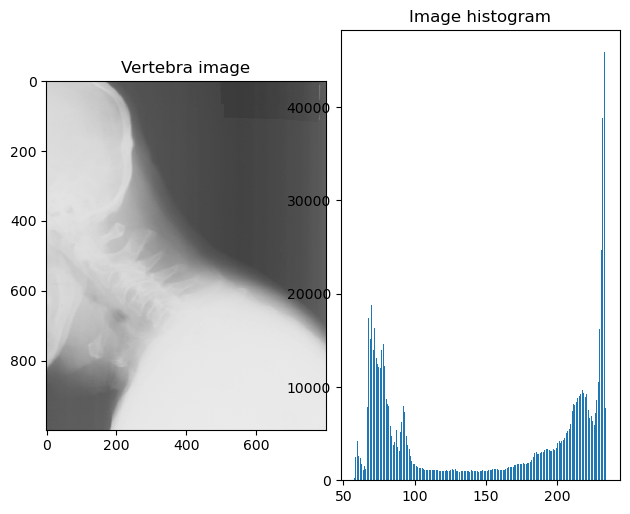

In [29]:
plt.figure()
plt.subplot(1,2,1)
io.imshow(im)
plt.title('Vertebra image')

plt.subplot(1,2,2)
plt.hist(im.ravel(), bins=256)
plt.title('Image histogram')

plt.show()
# si es bimodal y si creo que se puedan separar los huesos del fondo

## Exercise 2
Exercise 2: Compute the minimum and maximum values of the image. Is the full scale of the gray-scale spectrum used or can we enhance the appearance of the image?

In [34]:
minimo = im.ravel().min()
maximo = im.ravel().max()
print("El minimo es:", minimo)
print("El maximo es:", maximo)
print(f"El rango es: {[minimo,maximo]}")
#no se utiliza la escala completa de grises

El minimo es: 57
El maximo es: 235
El rango es: [57, 235]


# Pixel type conversions

## Conversion from unsigned byte to float image


El minimo float es:  0.22352941176470587
El maximo float es:  0.9215686274509803


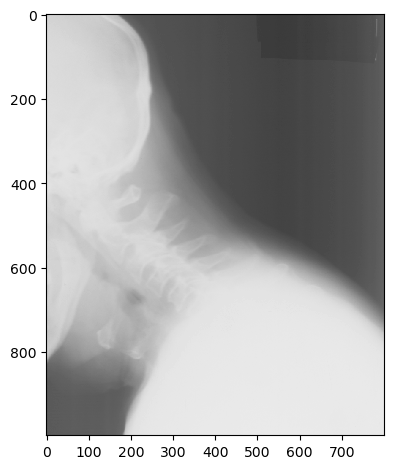

In [37]:
float_im = ski.img_as_float(im)
io.imshow(float_im)
float_min = float_im.ravel().min()
float_max = float_im.ravel().max()
print("El minimo float es: ", float_min)
print("El maximo float es: ", float_max)

# Conversion from float image to unsigned byte image
(Conversion de float a normal (*255))


El minimo float es:  57
El maximo float es:  235


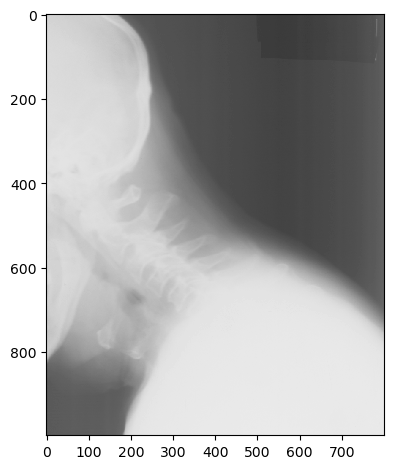

In [38]:
byte_im = ski.img_as_ubyte(float_im)
io.imshow(byte_im)
byte_min = byte_im.ravel().min()
byte_max = byte_im.ravel().max()
print("El minimo float es: ", byte_min)
print("El maximo float es: ", byte_max)

# fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12, 5))
# ax[0].imshow(im_org, vmin = 0, vmax = 255, cmap = 'gray')
# ax[0].set_title('Visualization window: [0, 255]')
# ax[1].imshow(im_org, vmin = min, vmax = max, cmap = 'gray') # Here, we change the visualization window, not the image itself!
# ax[1].set_title(f'Visualization window: [{min}, {max}]')
# plt.show()

In [ ]:
# Can you verify that the float image is equal to the original image, where each pixel value is divided by 255?
all_equal = np.allclose(im_org, im_float*255)
print(f'The float and the original image are equivalent?: {all_equal}')

# Histogram stretching
You should implement a function, that automatically stretches the histogram of an image. In other words, the function should create a new image, where the pixel values are changed so the histogram of the output image is optimal. Here optimal means, that the minimum value is 0 and the maximum value is 255. It should be based on the linear histogram stretching equation:

In [56]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
	
    img_out = ( (max_desired-min_desired) / (max_val-min_val)) * ((img_float-min_val) + min_desired)
    
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    plt.figure()
    
    plt.subplot(221)
    plt.hist(img_float.ravel())
    plt.title("Histogram before stretching")
    
    plt.subplot(222)
    io.imshow(img_float)
    plt.title("Image before stretching")
    
    plt.subplot(223)
    plt.hist(img_out.ravel())
    plt.title("Histogram after stretching")
    
    plt.subplot(224)
    io.imshow(img_out)
    plt.title("Image after stretching")
    
    plt.show()
    print(f"Max before stretching: {img_float.max():.2f} ")
    print("Max after stretching: ",img_out.max())
    return img_as_ubyte(img_out)

**Exercise 6**: Test your histogram_stretch on the vertebra.png image. Show the image before and after the histogram stretching. What changes do you notice in the image? Are the important structures more visible?

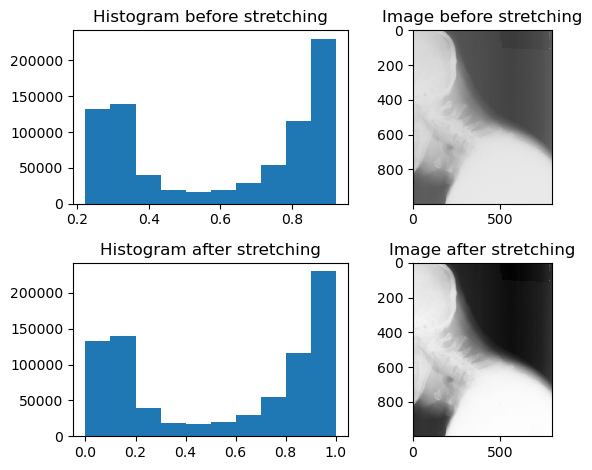

Max before stretching: 0.92 
Max after stretching:  1.0


array([[219, 219, 219, ...,  57,  57,  59],
       [222, 221, 221, ...,  57,  57,  59],
       [222, 221, 222, ...,  56,  57,  59],
       ...,
       [ 47,  47,  49, ..., 252, 252, 252],
       [ 49,  47,  49, ..., 252, 252, 254],
       [ 49,  49,  49, ..., 254, 254, 252]], dtype=uint8)

In [55]:
histogram_stretch(im)

# Non-linear pixel value mapping
The goal is to implement and test a function that performs a 
-mapping of pixel values:


You can use the Numpy function power to compute the actual mapping function.

**Exercise 7**: Implement a function, gamma_map(img, gamma), that:

- Converts the input image to float
- Do the gamma mapping on the pixel values
- Returns the resulting image as an unsigned byte image.

In [63]:
def gamma_map(img, gamma):
    img_float = ski.img_as_float(img)
    img_middle = np.power(img_float,gamma)
    img_out = ski.img_as_ubyte(img_middle)
    
    plt.figure()
    plt.subplot(121)
    io.imshow(img_float)
    plt.title("Image pre gamma")
    
        
    plt.subplot(122)
    io.imshow(img_out)
    plt.title("Image post gamma")
    
    plt.show()

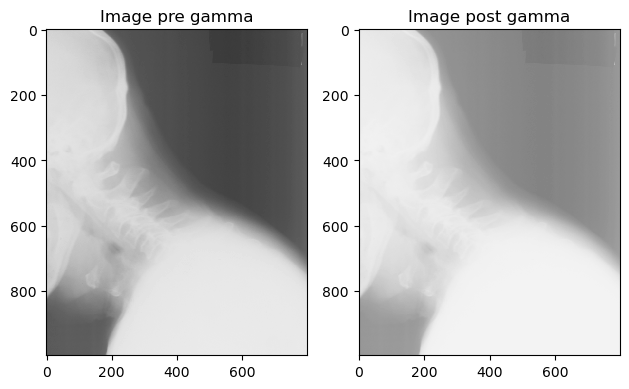

In [64]:
gamma_map(im, 0.5)

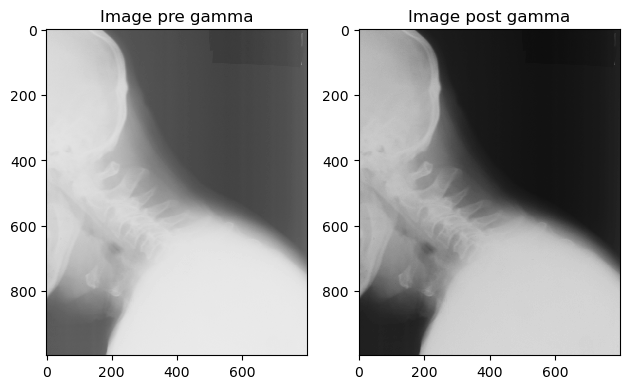

In [65]:
gamma_map(im, 2)

# Image segmentation by thresholding
Now we will try to implement some functions that can seperate an image into segments. In this exercise, we aim at seperating the background from the foreground by setting a threshold in a gray scale image or several thresholds in color images.

**Exercise 9**: Implement a function, threshold_image :

In [8]:
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    thres = thres/255
    img_float = ski.img_as_float(img_in)
    
    mask = img_float > thres
    
    img_out = ski.img_as_ubyte(mask)
    
    plt.figure()
    plt.subplot(121)
    io.imshow(img_float)
    plt.title("Image pre threshold")
    
        
    plt.subplot(122)
    io.imshow(img_out)
    plt.title("Image post threshold")
    
    plt.show()

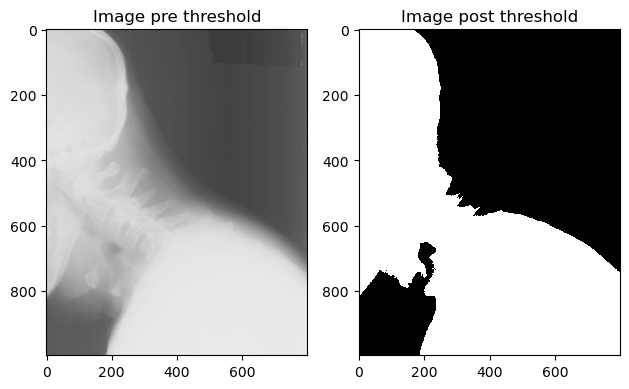

In [9]:
threshold_image(im, 175)

In [ ]:
# TA
def threshold_image(img_in, thres):
    """
    Apply a threshold in an image and return the resulting image
    :param img_in: Input image
    :param thres: The treshold value in the range [0, 255]
    :return: Resulting image (unsigned byte) where background is 0 and foreground is 255
    """
    mask = img_in > thres
    return img_as_ubyte(mask)

im_thres = threshold_image(im_org, thres = 110)

fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (12, 5))
ax[0].imshow(im_org, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].set_title('Original image')
ax[1].imshow(im_thres, cmap = 'gray', vmin = 0, vmax = 255)
ax[1].set_title('Foreground image')
ax[2].imshow(im_org, cmap = 'gray', vmin = 0, vmax = 255)
ax[2].contour(im_thres, [254, 256])
ax[2].set_title('Mask contour')
plt.show()

## Automatic thresholds using Otsu's method


In [10]:
def otsu_method(im):        
    #here we apply the otsu method // th2 is the otsu image
    ret2,th2 = cv.threshold(im,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(im, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(th2, cmap='gray')
    plt.title('Otsu umbralization')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

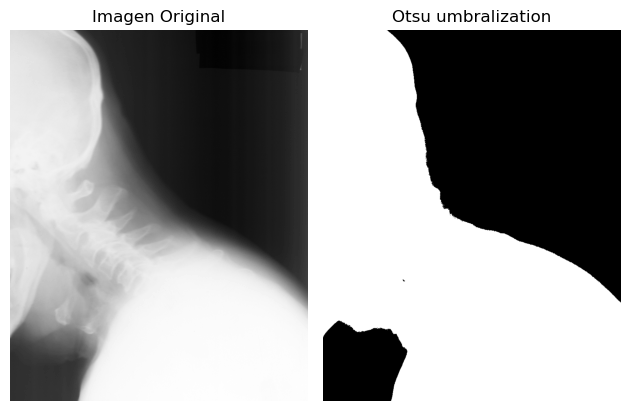

In [11]:
otsu_method(im)

In [ ]:
# TA
from skimage.filters import threshold_otsu

thres_new = threshold_otsu(im_org)
im_thres = threshold_image(im_org, thres = thres_new)

fig, ax = plt.subplots(nrows=1, ncols = 3, figsize = (12, 5))
ax[0].imshow(im_org, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].set_title('Original image')
ax[1].imshow(im_thres, cmap = 'gray', vmin = 0, vmax = 255)
ax[1].set_title(f'Foreground image [thres = {thres_new}]')
ax[2].imshow(im_org, cmap = 'gray', vmin = 0, vmax = 255)
ax[2].contour(im_thres, [254, 256])
ax[2].set_title('Mask contour')
plt.show()

In [ ]:
# TA SHILOUETTE
from skimage.color import rgb2gray

im_name = "dark_background.png"
im_org = io.imread(in_dir + im_name)

im_org = img_as_float(im_org)
im_gray = img_as_ubyte(rgb2gray(im_org))

thres = 5
im_thres = threshold_image(im_gray, thres = thres)

fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (12, 5))
ax[0].imshow(im_gray, cmap = 'gray', vmin = 0, vmax = 255)
ax[0].set_title('Original image')
ax[1].imshow(im_thres, cmap = 'gray', vmin = 0, vmax = 255)
ax[1].set_title(f'Silhouette')
plt.show()

## Color thresholding in the RGB color space
In the following, we will make a simple system for road-sign detection. Start by reading the image DTUSigns2.jpg found in the exercise data. We want to make a system that do a segmentation of the image - meaning that a new binary image is created, where the foreground pixels correspond to the sign we want to detect.

We do that by tresholding the colour-channels individually. This code segments out the blue sign:

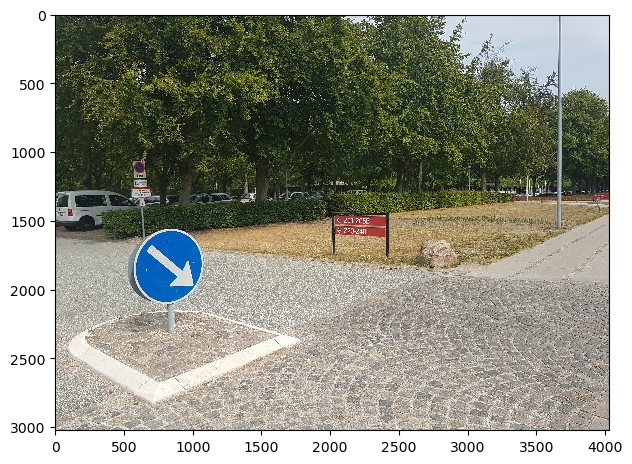

In [18]:
in_dir = "./data"
im_name = "/DTUSigns2.jpg"
img = io.imread(in_dir + im_name)
io.imshow(img)

In [16]:
%matplotlib inline 

def detect_dtu_signs(img_in, sign):
    r_comp = img_in[:, :, 0]
    g_comp = img_in[:, :, 1]
    b_comp = img_in[:, :, 2]

    if sign == 'red':
        segm = (r_comp > 160) & (r_comp < 180) & (g_comp > 50) & (g_comp < 80) & \
                    (b_comp > 50) & (b_comp < 80)
    if sign == 'blue':
        segm = (r_comp < 10) & (g_comp > 85) & (g_comp < 105) & \
                    (b_comp > 180) & (b_comp < 200)

    return img_as_ubyte(segm)

img_red = detect_dtu_signs(im_org, 'red')
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
ax[0].imshow(im_org)
ax[0].set_title('Original')
ax[1].imshow(img_red, vmin = 0, vmax = 255, cmap = 'gray')
ax[1].set_title('Red sign')
plt.show()

C:\Users\Usuario\dtu\env\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


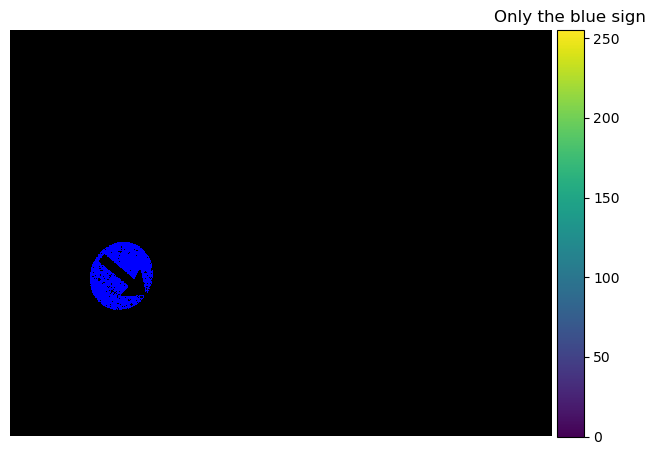

In [14]:
# Call the detect_dtu_signs function to get the segmented image
detect_dtu_signs(img)

**Exercise 14**: Extend your detect_dtu_signs function so it can also detect red signs. You can add an argument to the function, that tells which color it should look for. You should use one of the explorative image tools to find out what the typical RGB values are in the red signs.

## Color thresholding in the HSV color space


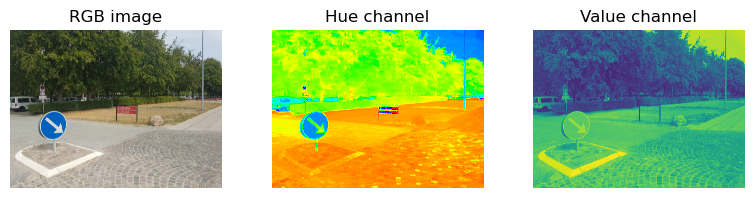

In [117]:
from skimage import color
hsv_img = color.rgb2hsv(img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))
ax0.imshow(img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()
io.show()

**Exercise 15**: Now make a sign segmentation function using tresholding in HSV space and locate both the blue and the red sign.



In [ ]:
%matplotlib inline 

segm_blue = (hue_img < 0.6) & (hue_img  > 0.4) & (value_img < 0.77) & (value_img > 0.70)
segm_red = (hue_img < 1.0) & (hue_img  > 0.9)

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))
ax1.imshow(segm_blue, cmap = 'gray')
ax1.set_title('DTU sign image (Blue)')

ax2.imshow(segm_red, cmap = 'gray')
ax2.set_title('DTU sign image (Red)')
plt.show()

# Real time pixelwise operations on videos
In the exercise material, there is a Python script using OpenCV that:

Connects to a camera
Acquire images, converts them to gray-scale
Do a simple processing on the gray-scale (inversion) or the colour image (inversion of the red channel)
Computes the frames per second (fps) and shows it on an image.
Shows input and resulting images in windows.
Checks if the key q has been pressed and stops the program if it is pressed.
It is possible to use a mobile phone as a remote camera by following the instructions in exercise 2b.

**Exercise 16**: *Run the program from the exercise material and see if it shows the expected results? *
**Exercise 17**: Change the gray-scale processing in the exercise material script to be for example thresholding, gamma mapping or something else. Do you get the visual result that you expected?

**Exercise 18**: Real time detection of DTU signs

Change the rgb-scale processing in the exercise material script so it does a color threshold in either RGB or HSV space. The goal is to make a program that can see DTU street signs. The output should be a binary image, where the pixels of the sign is foreground. Later in the course, we will learn how to remove the noise pixels.
